In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer

from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)


# Load Dataset

In [2]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


# Text Preprocessing

### Denoising the text:
remove HTML tags, square brackets, punctuations and special characters.

### Remove Stopwords:
remove words which do not add useful information to the classifier.

In [4]:
#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text.lower()

imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [5]:
print('Sample Text after denoising:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after denoising:


'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done '

In [6]:
#text tokenizer
tokenizer=ToktokTokenizer()

#get list of stopwords
stop=set([re.sub(r'[^a-zA-z0-9\s]', '', st) for st in stopwords.words('english')])

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [7]:
print('Sample Text after filtering:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after filtering:


'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [8]:
'''Additional preprocessing'''
#stem the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [9]:
print('Sample Text after stemming:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after stemming:


'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [11]:
train_imdb, test_imdb = train_test_split(imdb_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_imdb['review'].values,train_imdb['sentiment'].values,test_imdb['review'].values,test_imdb['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 35000 samples
Test data has 15000 samples


# vectorize text

In [12]:
#vectorize dataset
def tokenize_text(x_train,y_train,x_val,y_val):
    word_list = []
 
    for sent in x_train:
        for word in sent.split():
            if word != '':
                word_list.append(word)
    
    #make vocab dictionary
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tokenize
    train_sent,test_sent = [],[]
    for sent in x_train:
            train_sent.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])
    for sent in x_val:
            test_sent.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

    return np.array(train_sent), y_train,np.array(test_sent), y_val,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize_text(x_train,y_train,x_test,y_test)

In [13]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 5000


In [14]:
#pad with zeros
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train, 100)
x_test_pad = padding_(x_test, 100)

# Discriminative Process for classification

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [16]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train.astype('int')))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [17]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input features: \n', sample_x)
print('Sample input labels: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input features: 
 tensor([[   0,    0,    0,  ...,  818,  443,  169],
        [  20,   65,  105,  ...,  165, 2157,  208],
        [ 127,   30,  276,  ..., 1318, 1281,   88],
        ...,
        [   0,    0,    0,  ...,   16,  435,  607],
        [   0,    0,    0,  ...,  120,  125,    8],
        [   0,    0,    0,  ...,   38, 3955,  525]])
Sample input labels: 
 tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1])


### LSTM neural network model

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self,n_layers,vocab_size,hidden_dim,embedding_dim):
        super(LSTMClassifier,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.n_layers = n_layers
        self.vocab_size = vocab_size

        #embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = torch.nn.LSTM(input_size = embedding_dim, 
                                 hidden_size = self.hidden_dim,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 dropout = 0.2)

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        #linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
        

In [19]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [20]:
n_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 100
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)


LSTMClassifier(
  (embedding): Embedding(5001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [21]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [22]:
clip = 5
epochs = 5
best_loss = float('inf')
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break
        
        inputs, labels = inputs.to(device), labels.to(device) 
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(epoch+1,
    epochs, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100)
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss,epoch_val_loss))
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70*'==')


Epoch[1/5], Train Loss: 0.5409 | Valid Loss: 0.4279 | Train Acc: 72.58 | Valid Acc: 80.37
Validation loss decreased (inf --> 0.427878).  Saving model ...
Epoch[2/5], Train Loss: 0.3861 | Valid Loss: 0.3612 | Train Acc: 83.39 | Valid Acc: 84.57
Validation loss decreased (0.427878 --> 0.361180).  Saving model ...
Epoch[3/5], Train Loss: 0.3150 | Valid Loss: 0.3509 | Train Acc: 87.07 | Valid Acc: 84.71
Validation loss decreased (0.361180 --> 0.350872).  Saving model ...
Epoch[4/5], Train Loss: 0.2639 | Valid Loss: 0.3490 | Train Acc: 89.51 | Valid Acc: 85.36
Validation loss decreased (0.350872 --> 0.349016).  Saving model ...
Epoch[5/5], Train Loss: 0.2106 | Valid Loss: 0.3734 | Train Acc: 91.77 | Valid Acc: 84.86


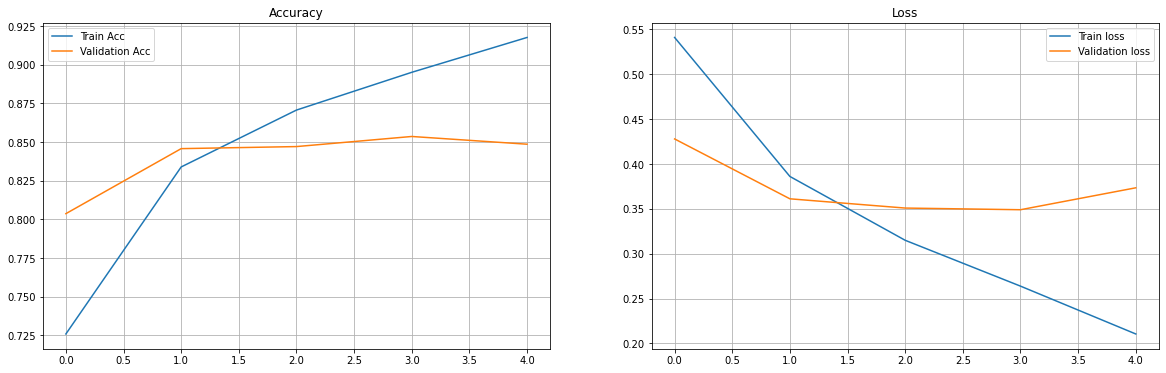

In [23]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [24]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc*100/len(valid_loader.dataset)))

Test Accuracy: 85.61


Text(0.5, 1.0, 'class 0 (specificity): 0.863 | class 1 (sensitivity): 0.849')

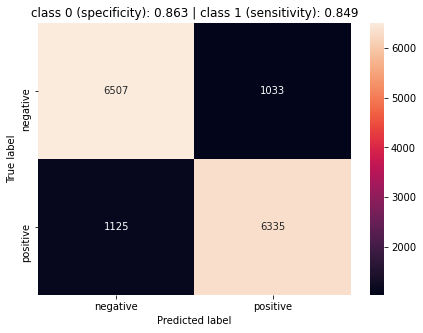

In [25]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

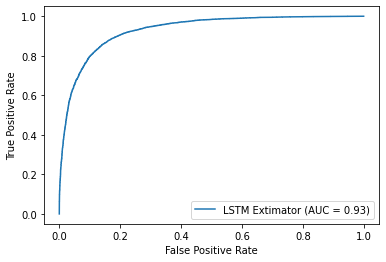

In [26]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [27]:
x_test_real,y_test_real = test_imdb['review'].values,test_imdb['sentiment'].values

def tokenize_test(x_test_real, vocab):
    test_sent=[]
    for sent in x_test_real:
        test_sent.append([vocab[word] for word in sent.split() if word in vocab.keys()])
    return np.array(test_sent)

x_test_real = tokenize_test(x_test_real, vocab)

In [28]:
def predict_text(text):
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,100))
        inputs = pad.to(device)
        batch_size = 1
        h = best_model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = best_model(inputs, h)
        return(output.item())

sentiment_dict = {1:'positive', 0:'negtive'}

In [29]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

short comment want say like movi much sandra bullock favourit actress like whole stori begin end tape watch 100 time matter
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.8531335592269897


In [30]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

compos eleg carol marvel play beauti rebecca brook nice husband eddi likabl david houseman carol wacki constantli eat best gal pal anna delight essay infecti comic zeal ador chri jordan anna hunki amor husband pete typic fine eric edward quartet liber swinger enjoy frequent group sex usual routin get disrupt carol lone repress still allur widow mother jennif superbl move perform love jennif well drop visit pretti soon jennif loosen becom will particip swinger blith pleasur uninhibit carnal lifestyl everyon except carol eager seduc writerdirector joe sarno concoct sharp engross percept examin suburban angst limit whole wildneasi 70 sexual revolut sarno turn tradit middl class more head spice thing bold provoc motherdaught incest subplot moreov sarno elicit uniformli first rate act bang cast well brook except excel support edward jordan houseman arlana blue flaki new age sex therapist shandara erica eaton sauci neighbor mr field better still women extrem hot entic well particular serious

# synthetic data prep and evaluation

In [31]:
syn_data=pd.read_csv('generated_review.csv')
print(syn_data.shape)
syn_data.head(10)

(10000, 2)


,review,sentiment
0,brush sport find appropri preced nun 1987 susp...,1
1,worthless compos melt abil process chang catho...,1
2,weav grey buff grandfath li sincer pair argent...,1
3,niec box streep label cruel sourc sarandon sch...,1
4,dane murray spoof vagu illumin chucki account ...,1
5,goal superhero beyond ranger gloriou eeri shak...,1
6,engross someon sea viewer daniel greg exposur ...,1
7,signific portray score han launch die ya donal...,1
8,finish andi motorcycl hindi enthral max subtl ...,1
9,clad scorses crown septemb cook deliber quaid ...,1


In [32]:
train_syn, test_syn = train_test_split(syn_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_syn['review'].values,train_syn['sentiment'].values,test_syn['review'].values,test_syn['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

Train data has 7000 samples
Test data has 3000 samples


In [33]:
#vectorize synthetic data
x_train,y_train,x_test,y_test,vocab = tokenize_text(x_train,y_train,x_test,y_test)
x_train_pad = padding_(x_train, 100)
x_test_pad = padding_(x_test, 100)

In [34]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train.astype('int')))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [35]:
n_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 100
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [36]:
clip = 5
epochs = 5
best_loss = float('inf')
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break
        
        inputs, labels = inputs.to(device), labels.to(device) 
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(epoch+1,
    epochs, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100)
    print(to_print)
    if epoch_val_loss <= best_loss:
        #torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss,epoch_val_loss))
        best_loss = epoch_val_loss
        best_model_syn = copy.deepcopy(model)
    print(70*'==')


Epoch[1/5], Train Loss: 0.6850 | Valid Loss: 0.6521 | Train Acc: 54.87 | Valid Acc: 61.50
Validation loss decreased (inf --> 0.652086).  Saving model ...
Epoch[2/5], Train Loss: 0.5305 | Valid Loss: 0.5027 | Train Acc: 74.64 | Valid Acc: 77.77
Validation loss decreased (0.652086 --> 0.502735).  Saving model ...
Epoch[3/5], Train Loss: 0.3523 | Valid Loss: 0.4620 | Train Acc: 85.89 | Valid Acc: 79.53
Validation loss decreased (0.502735 --> 0.462043).  Saving model ...
Epoch[4/5], Train Loss: 0.2196 | Valid Loss: 0.3592 | Train Acc: 92.00 | Valid Acc: 86.23
Validation loss decreased (0.462043 --> 0.359159).  Saving model ...
Epoch[5/5], Train Loss: 0.1318 | Valid Loss: 0.3928 | Train Acc: 95.53 | Valid Acc: 86.27


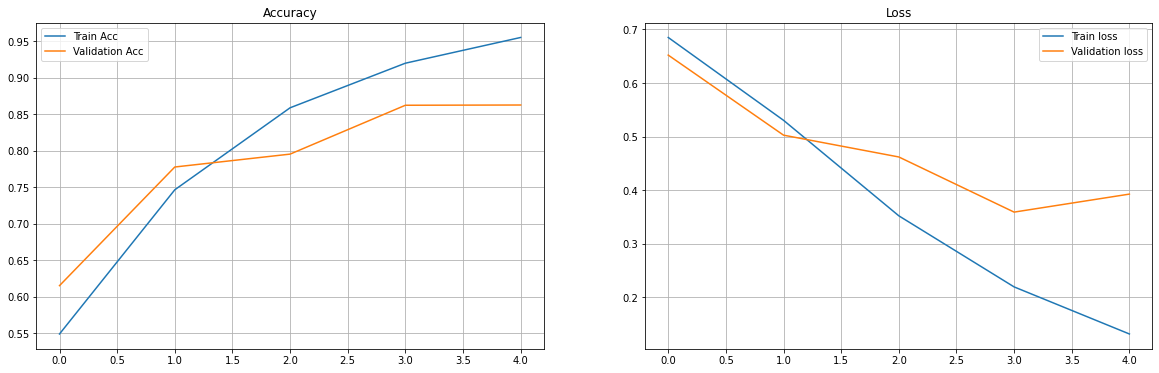

In [37]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [38]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = best_model_syn.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = best_model_syn(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc*100/len(valid_loader.dataset)))

Test Accuracy: 86.30


Text(0.5, 1.0, 'class 0 (specificity): 0.852 | class 1 (sensitivity): 0.874')

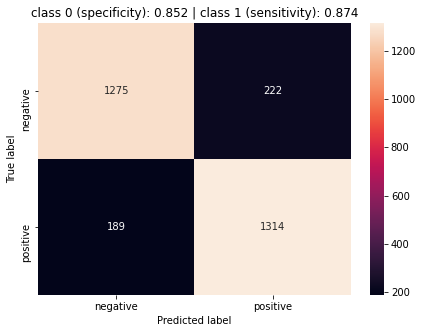

In [39]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

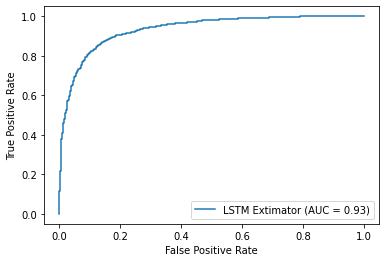

In [40]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [41]:
def predict_text(text, network = best_model_syn, vocab = vocab):
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,100))
        inputs = pad.to(device)
        batch_size = 1
        h = network.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = network(inputs, h)
        return(output.item())

sentiment_dict = {1:'positive', 0:'negtive'}

In [42]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

heartbreak tendenc pimp altogeth jonathan chess that late robert facil logan deriv championship eager compromis fashion melvil firstli fabric veteran lie insist small frontier flawless live pattern tad culmin le friend st tag 13th younger stuart ah recent lot streisand impos furiou aveng gritti outing mari exactli deliv footag flow con wouldv madonna mistaken farm given ban delv manipul jake delv lincoln definit noah carter york 16 off beauti amazon rank unexpect share vera head laps nervou confus defi proof soundtrack burt lawrenc countri ballet bogart regard fate folk overlook insur toward trend
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.89715975522995


In [43]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

offici award domest victoria found atmospher rotten read abrupt monologu genet notic fx potenti categori massiv grass pathet contain abraham calm 1993 wive ive last cook threaten hesit summari way arab relev effect 1968 review dash khan 1989 privat asham hung physic 2nd therefor ordinari go argu counti led u kubrick million kong insipid jane bin satisfi pay go upsid perspect want creat elsewher dancer lake captiv vision fulci debbi button form chest medic stretch sustain matrix hill measur 0 dolph blair linda cruel ie antagonist bakshi humor corni funer unlik clerk wallac standard done von visitor servant
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.956033643335104


# evaluating model trained on synthetic data on real world test data

In [45]:
#replace synthetic test set with real world test set
x_test,y_test = test_imdb['review'].values,test_imdb['sentiment'].values

def tokenize_test(x_test, vocab):
    test_sent=[]
    for sent in x_test:
        test_sent.append([vocab[word] for word in sent.split() if word in vocab.keys()])
    return np.array(test_sent)

x_test = tokenize_test(x_test, vocab)
x_test_pad = padding_(x_test, 100)
y_test = y_test.astype('int64')

test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))
valid_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [46]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = best_model_syn.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = best_model_syn(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc*100/len(valid_loader.dataset)))

Test Accuracy: 71.62


Text(0.5, 1.0, 'class 0 (specificity): 0.868 | class 1 (sensitivity): 0.563')

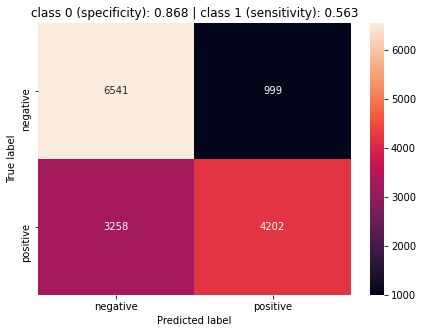

In [47]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

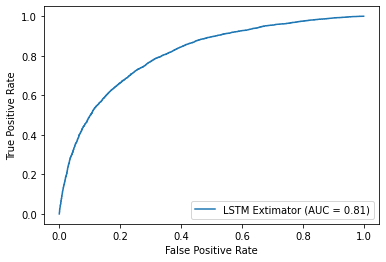

In [48]:
fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [49]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

sunshin boy terrif comedi two ex vaudevillian reluctantli reunit tv special despit fact despis comic geniu two master work georg burn walter matthau stellar best scene duo fight silliest littl trivial thing materi fast pace witti appeal age mild spoiler alert mildli sad moment toward end movi deal indirectli affect age give film soft sincer tender show review pair realli need success anyon love odd coupl ador movi excel film
Actual sentiment is  : positive
Predicted sentiment is negative with a probability of 0.7296298742294312


In [50]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

love show think first time tri rocki road ice cream due show shop locat like right beach someth actual wrote back forth marci sever year lost touch wish could reconnect adult anyon know wish would put dvd serious doubt sinc think mayb like five six peopl even rememb show air first place make show like anymor wonder would still hold day age guy know anyon could burn dvd show tape vh id will paywithin reason
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9627036452293396
